In [1]:
# MNIST Handwritten Digit Recognition in PyTorch
# training a classifier on MNSIT can be regarded as "hello world" in image recognition

In [2]:
# things we will use here are
## pytorch, MNSIT dataset (I will share the versions in readme)


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
# torchvision.transforms
## these are common image transformations [eg: ToTensor(), Normalize()]
# torchvision.transforms.compose 
## composes several transforms together
### check https://pytorch.org/docs/stable/torchvision/transforms.html for more info.

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))])

In [6]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)

In [7]:
# why are we even using transform?
## what is that normalize? 
## are the values same everytime?
## how to determine them?

## Normalize does the following for each channel: image = (image - mean) / std
## the above values standard values, but in real life scenarios, we need to normalize them according to out convenience

## other important transform is cropping

In [8]:
# Dataloading
## This is the toughest part in real life problems
## DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
#            batch_sampler=None, num_workers=0, collate_fn=None,
#            pin_memory=False, drop_last=False, timeout=0,
#            worker_init_fn=None, *, prefetch_factor=2,
#            persistent_workers=False)

# dataset torch.utils.data.Dataset
# here we are using MNIST dataset

In [9]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/', train = True, download = True, transform = transform), batch_size = 64, shuffle = True)

# here is used transform = transform, you can use other name in the above step and use the same here [eg: transform = autobot]

In [10]:
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./files/', train = False, download = False, transform = transform), batch_size = 100, shuffle = True)

In [11]:
train_loader

In [12]:
len(train_loader)

938

In [13]:
test_loader

In [14]:
len(test_loader)

100

In [15]:
#let's test this properly now
## who trusts this torch thing right? Let's test on our own if whether this data is loaded or not

In [16]:
examples = enumerate(test_loader) # enumerate is just for adding index (atleast that's what I use it for) https://www.geeksforgeeks.org/enumerate-in-python/
batch_idx, (example_data, example_targets) = next(examples)

In [17]:
example_data.shape

torch.Size([100, 1, 28, 28])

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1) # just making a grid thing (2*3)
    plt.tight_layout() 
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i])) # example_targets are the actual numbers 1,2,3,4,5,6,7,8,9,0
    plt.xticks([])
    plt.yticks([])
fig

<Figure size 640x480 with 6 Axes>

In [19]:
# dang! these are really loaded
# but data pre-processing and loading won't be this easy. As you know, this is basic

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
#  We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers
# As activations, we will chose ReLU and as a means of regularization we'll use two dropout layers

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) # convolution layer with 1 in-channel and 10 out-channels and kernel-matrix 5*5
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # convolution layer with 10 in-channels and 20 out-channels and kernel-matriz 5*5
        self.conv2_drop = nn.Dropout2d() # Randomly zero out entire channels [TO AVOID OVERFITTING]
        # During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution.
        #Each channel will be zeroed out independently on every forward call.
        self.fc1 = nn.Linear(320, 50) # 320 in-features and 50 out-features
        self.fc2 = nn.Linear(50, 10) # 50 in-features and 10 out-features
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # to reduce the number of parameters which is imperative to reducing computation [2 makes the parameters by half in each dimension]
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # ReLU is activation function
        x = x.view(-1, 320) # last 320 features
        x = F.relu(self.fc1(x)) 
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
        

In [23]:
# yayyy! we created a neural network
# forward is how you define your module is going to run

In [24]:
network = Net() # creating an instance of that network
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5) # stochastic gradient descent

In [25]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(4)] # 4 is number of epochs
log_interval = 10

In [26]:
# training
# First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients.
# We then produce the output of our network (forward pass)
# and compute a negative log-likelihodd loss between the output and the ground truth label.

In [27]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target) # nll loss (negative likelihood explained)
    loss.backward() 
    # The backward() call we now collect a new set of gradients which we propagate back 
    # into each of the network's parameters using optimizer.step()
    optimizer.step() 
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/mnist_model.pth')
      torch.save(optimizer.state_dict(), './results/mnist_optimizer.pth')

In [28]:
# testing 
## Neural network modules as well as optimizers have the ability to save and load their internal state using .state_dict(). 
## With this we can continue training from previously saved state dicts if needed - we'd just need to call .load_state_dict(state_dict). 

In [29]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [30]:
# Using the context manager no_grad() we can avoid storing the computations done producing the output of our network in the computation graph

In [31]:
for epoch in range(1, 5): # number of epochs is 4
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304425
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.302078
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.301968
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.273733
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.277233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.226111
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.248716
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.265962
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.190775
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.140408
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.133085
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.126921
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.966429
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.748029
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.677428
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.623252
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.367629
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.368058
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.379836
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.459766
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2016, Accuracy: 9436/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.400916
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.453189
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.248654
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.409699
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.473577
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.429770
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.274144
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.536625
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.435851
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.348478
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.334948
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.528722
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.302746
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.347114
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.424060
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.447388
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.407330
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.517509
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.296273
Train Epoch: 2 [12160

In [32]:
# test()
print(len(test_counter), len(test_losses))

4 4


In [33]:
print(len(train_counter))
print(len(train_losses))

376
376


In [35]:
# 98% accuracy
# not very often
# let's plot how our data got trained

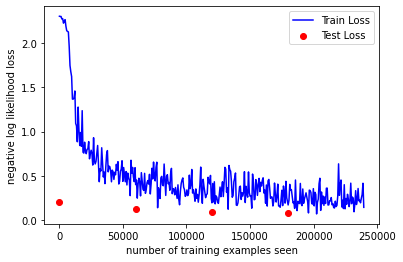

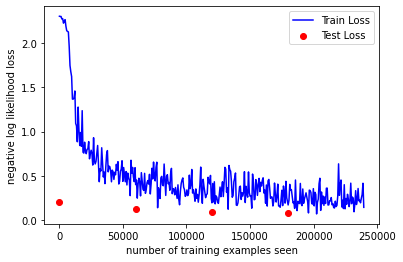

In [34]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig